# Introduction to pycalphad
### MatSE 501
### Brandon Bocklund


## Getting help

* [pycalphad examples](https://github.com/pycalphad/pycalphad/tree/develop/examples)
* [API documentation](https://pycalphad.org/docs/latest/api/modules.html)
* For classwork: [bocklund@psu.edu](mailto:bocklund@psu.edu)


## Core concepts

Any calculation in pycalphad requires you to define
* A Database
* The components to consider (including `'VA'` for vacancies)
* The phases to consider
* The conditions of the calculation


### Defining a Database

Most thermodynamic databases are stored as TDB files, which are widely supported in thermodynamic software.
We'll load a Cr-Fe-Ni database to use here.

To load a database from a file:

In [7]:
from pycalphad import Database

db = Database('Cr-Fe-Ni.tdb')

Print the available elements:

(Note that `'/-'` is the null species and is mostly included out of convention)

In [8]:
print(db.elements)

{'FE', '/-', 'CR', 'NI', 'VA'}


And phases:

In [9]:
print(list(db.phases.keys()))

['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3', 'SIGMA']


Note that not all phases can be defined for every calculation. When all of the sublattices do not have at least one of the defined component defined, that phase may not be included. The SIGMA phase has only Cr definedin the second sublattice, and thus cannot be used when Cr is not a component.

In [14]:
print(db.phases['SIGMA'].constituents)

(frozenset({'NI', 'FE'}), frozenset({'CR'}), frozenset({'CR', 'NI', 'FE'}))


### Conditions

In any thermodynamic calculation, $c+2$ conditions must be defined for $c$ components.
In pycalphad, we always calculate molar quantites, with the implicit condition that $n=1$, so all calculations must have $c+1$ conditions specified.

Each condition, pressure, temperature and composition are accessed via by prepending the type with a `v`:

* Pressure: `v.P` in Pacals. Usually (but not always) thermodyanmic databases do not consider pressure and thus you use standard pressure, 101325 Pa by convention.
* Temperature: `v.T` in Kelvin.
* Composition: `v.X('NI')` as a mole fraction.

### Sample equilibrium calculation

In [37]:
from pycalphad import equilibrium
from pycalphad import variables as v

# Define components:
# Note: must have the correct capitialization.
# CALPHAD modelers usually use all-caps by convention.
# Also not that we include VA. Always do this.
components = ['CR', 'NI', 'VA'] 

# Define the phases:
phases = ['LIQUID', 'BCC_A2', 'FCC_A1']

# And the conditions:
# We want to see which phases are presnt when 10% Cr is in Ni 
# This is a map of the variable to its value
conditions = {
    v.P: 101325,
    v.T: 500,
    v.X('CR'): 0.20
        }

# do the equlibrium calculation and store the result in the `eq` variable
eq = equilibrium(db, components, phases, conditions)

/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


If you got a warning in the above cell, that's ok.

Now we will look at what pycalphad calculated in the `eq` object. It is an [xarray](http://xarray.pydata.org/en/stable/) dataset.

xarray allows for the storage of values such as the stable phases, Gibbs energies, chemical potentials, as values over a grid of our conditions and phases given by the Gibbs phase rule.

If you want to learn more about xarray Datasets, see the [xarray documentation](http://xarray.pydata.org/en/stable/).

Below you can see the dimensions (the grid of conditions) and the data variables (things that we calculated as a function of the different dimensions). The coordinates are just things we can index over, for convience.

In [38]:
print(eq)

<xarray.Dataset>
Dimensions:    (P: 1, T: 1, X_CR: 1, component: 2, internal_dof: 3, vertex: 2)
Coordinates:
  * P          (P) float64 1.013e+05
  * T          (T) float64 500.0
  * X_CR       (X_CR) float64 0.2
  * vertex     (vertex) int64 0 1
  * component  (component) <U2 'CR' 'NI'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (P, T, X_CR, vertex) float64 1.0 nan
    GM         (P, T, X_CR) float64 -1.829e+04
    MU         (P, T, X_CR, component) float64 -1.468e+04 -1.919e+04
    X          (P, T, X_CR, vertex, component) float64 0.2 0.8 nan nan
    Y          (P, T, X_CR, vertex, internal_dof) float64 0.2 0.8 1.0 0.1996 ...
    Phase      (P, T, X_CR, vertex) <U6 'FCC_A1' ''
Attributes:
    engine:   pycalphad 0.5.2.post1
    created:  2017-10-19T02:35:20.768811


You can see we calculated

* NP: the phase fraction
* GM: the molar Gibbs free energy
* MU: the chemical potentials
* X: The overall composition of each element in each phase (the *constitution*)
* Y: The site fractions (compositions of each sublattice) in each phase
* Phase: the name of the stable phase

Let's look at the values for the phase that was stable:

Note that the empty set of parenthesis means that there could have been a second phase there by Gibbs phase rule.

In [39]:
print(eq.Phase.values.squeeze())

['FCC_A1' '']


And now the chemical potentials in that phase where we select (`sel`) our temperature, pressure, and Cr compositions:

In [41]:
print(eq.MU.sel(T=500, P=101325, X_CR=0.20))

<xarray.DataArray 'MU' (component: 2)>
array([-14676.905267, -19190.751151])
Coordinates:
    P          float64 1.013e+05
    T          float64 500.0
    X_CR       float64 0.2
  * component  (component) <U2 'CR' 'NI'


Where the values of the chemical potential for Cr is -14676 J/mol and -19190 J/mol for Ni, as seen in their alignment with the coordinates.

## Free energy curves

Now lets see if that chemical potential makes sense based on the free energy curves. The next section plots the free energy curves for all the phases we defined before.

Note that we are using the `calculate` function, rather than `equilibrium`. 

`calculate` is slightly different than equilibrium in that it doesn't find the minimum energy, but rather samples all of the energies in the internal degrees of freedom. Hence, we do not have to specify any composition conditions and we specify temperature and pressure directly.

We'll plot the line between the chemical potentials we just calculated in red.

/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:57: RuntimeWarning: divide by zero encountered in log
  pts = -np.log(pts)
/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:61: RuntimeWarning: invalid value encountered in true_divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


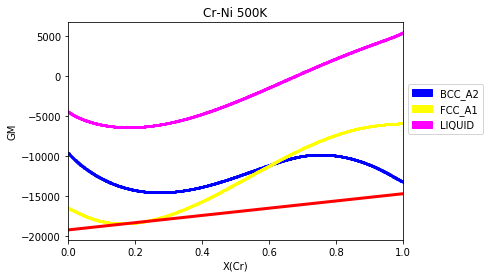

In [74]:
%matplotlib inline
from pycalphad import calculate
from pycalphad.plot.utils import phase_legend
import matplotlib.pyplot as plt
import numpy as np

legend_handles, colorlist = phase_legend(sorted(phases))

fig = plt.figure()
ax = fig.gca()
ax.set_title('Cr-Ni 500K')
ax.set_ylabel('GM')
ax.set_xlabel('X(Cr)')
for phase in phases:
    result = calculate(db, components, phase, T=500, P=101325, output='GM')
    ax.scatter(result.X.sel(component='CR'), result.GM,
               marker='.', s=5, color=colorlist[phase.upper()])
ax.set_xlim((0, 1))
ax.plot([0, 1], [-19190, -14676], color='red', linewidth=3)
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))


You can see that the line between the chemical potentials we calculated is indeed tangent to the Gibbs free energy of the FCC phase.

Moving to higher temperature, we can see the same effect between two phases:

/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))
/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:57: RuntimeWarning: divide by zero encountered in log
  pts = -np.log(pts)
/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:61: RuntimeWarning: invalid value encountered in true_divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


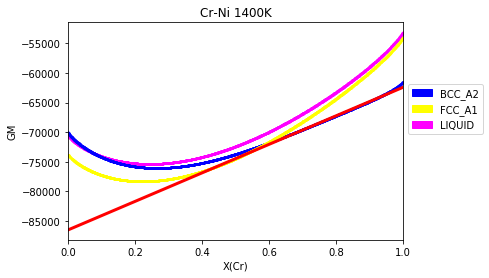

In [76]:
T = 1400

# note that we can directly replace the variables with their values in the equilibrium function
eq_2 = equilibrium(db, components, phases, {v.P: 101325, v.T: T, v.X('CR'): 0.80})


fig = plt.figure()
ax = fig.gca()
ax.set_title('Cr-Ni {}K'.format(T))
ax.set_ylabel('GM')
ax.set_xlabel('X(Cr)')
for phase in phases:
    result = calculate(db, components, phase, T=T, P=101325, output='GM')
    ax.scatter(result.X.sel(component='CR'), result.GM,
               marker='.', s=5, color=colorlist[phase.upper()])
ax.set_xlim((0, 1))
# note that here we are indexing the chemical potentials by the selecting by *index* (isel)
ax.plot([1, 0], eq_2.MU.isel(P=0, T=0, X_CR=0), color='red', linewidth=3)
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))


##  Binary phase diagram

The equilibria along these individual energy curves can be built up to make a whole phase diagram.

Here we use `binplot` (binary plot) as a shortcut, which takes the same database, components, phases and conditions. However we would like our phase diagram to be over many temperatures and compositions, rather than a single point, so we have to express that in the conditions.

We will redefine our conditions to have the same kinds of conditions, however now the values in the parenthesis determine the `(min, max, step)` of our phase diagram calculations:

Note that this may take a minute or two. If you get a warning (in red), it is ok.

/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


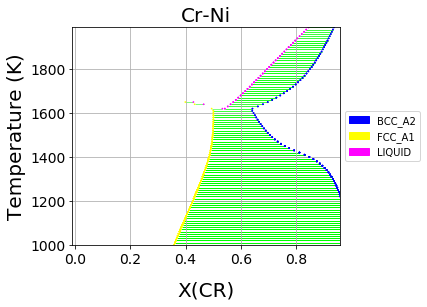

In [73]:
from pycalphad import binplot

conditions = {
    v.P: 101325,
    v.T: (1000, 2000, 10), # (min, max, step)
    v.X('CR'): (0, 1, 0.05)
        }

binplot(db, components, phases, conditions)

## Ternary (isothermal) phase diagram

For higher order equilibrium and other calculations, the procedure is mostly the same.

pycalphad can do equilibrium calculations of arbitrarily high-dimensioned systems (n-components, p-phases), but we are currently limited the visualizing in 2D. 

We can plot an isothermal Gibbs triangle phase diagram using `ternplot`, the ternary version of `binplot`.

/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))
/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:57: RuntimeWarning: divide by zero encountered in log
  pts = -np.log(pts)
/Users/brandon/anaconda3/envs/pycalphad-release/lib/python3.6/site-packages/pycalphad/core/utils.py:61: RuntimeWarning: invalid value encountered in true_divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1700.0)), ('X_CR', array(0.07500000000000001)), ('X_NI', array(0.9))])


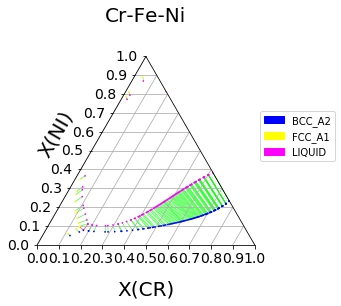

In [90]:
from pycalphad import ternplot

tern_comps = ['CR', 'FE', 'NI', 'VA']
tern_phases = list(db.phases.keys())
conditions = {
    v.P: 101325,
    v.T: 1700, # (min, max, step)
    v.X('CR'): (0, 1, 0.025),
    v.X('NI'): (0, 1, 0.025),
        }

ternplot(db, tern_comps, tern_phases, conditions)

## More

pycalphad can also be used to 

- calculate properties such as degree of ordering or mixing enthalpy as in the Gibbs energy above
- calculate and visualize the equilibrium properties
- develop custom models 

See [pycalphad.org](https://pycalphad.org) for some examples.
